In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
import seaborn as sns
sns.set()

Change the path to import classes!

In [6]:
sys.path.append('/Users/mikhail/projects/edu/skoltech/ml/project/RF-online/src/')

In [ ]:
from offline.decision_tree import DecisionTreeClassifier
from offline.random_forest import RandomForestClassifier

### Data preprocessing

Load datasets for the experiments, deal with NaNs and encode categorical features (if necessary), split in train and test sets. All datasets are contained in one dictionary. 

In [ ]:
PATH = '/Users/mikhail/projects/edu/skoltech/ml/project/RF-online/data/'

In [ ]:
datasets = {'usps': {}}

Load USPS dataset https://www.kaggle.com/bistaumanga/usps-dataset/version/1

In [ ]:
with h5py.File(PATH + 'usps.h5', 'r') as hf:
        train = hf.get('train')
        datasets['usps']['X_train'] = train.get('data')[:]
        datasets['usps']['y_train'] = train.get('target')[:]
        test = hf.get('test')
        datasets['usps']['X_test'] = test.get('data')[:]
        datasets['usps']['y_test'] = test.get('target')[:]

Load letter dataset https://archive.ics.uci.edu/ml/datasets/letter+recognition

In [ ]:
cols = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar',
       'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege',
       'xegvy', 'y-ege', 'yegvx'
       ]

letter_dataset = pd.read_csv(PATH + 'letter-recognition.data.txt', sep=',', names=cols)

In [10]:
letter_dataset.head(5)

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [11]:
letter_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
lettr    20000 non-null object
x-box    20000 non-null int64
y-box    20000 non-null int64
width    20000 non-null int64
high     20000 non-null int64
onpix    20000 non-null int64
x-bar    20000 non-null int64
y-bar    20000 non-null int64
x2bar    20000 non-null int64
y2bar    20000 non-null int64
xybar    20000 non-null int64
x2ybr    20000 non-null int64
xy2br    20000 non-null int64
x-ege    20000 non-null int64
xegvy    20000 non-null int64
y-ege    20000 non-null int64
yegvx    20000 non-null int64
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


Encode the target

In [ ]:
letter_dataset['lettr'] = letter_dataset['lettr'].astype('category')

In [ ]:
letter_dataset['lettr'] = letter_dataset['lettr'].cat.codes

In [14]:
letter_dataset.head(5)

,lettr,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,19,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,8,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,3,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,13,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,6,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [ ]:
X = letter_dataset.iloc[:, 1:].values
y = letter_dataset.iloc[:, 0].values

Split into train and test sets

In [ ]:
datasets['letters'] = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True)
datasets['letters']['X_train'] = X_train
datasets['letters']['X_test'] = X_test
datasets['letters']['y_train'] = y_train
datasets['letters']['y_test'] = y_test

In [17]:
X_test.shape

(6000, 16)

Load mushrooms dataset https://archive.ics.uci.edu/ml/datasets/mushroom

In [18]:
cols = ['target', 'cap-shape', 'cap-surface', 'cap-color', 'odor', 'high', 'gill-attachment', 'gill-spacing',
       'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
        'spore-print-color', 'population', 'habitat'
       ]
mushroom_dataset = pd.read_csv(PATH + 'agaricus-lepiota.data.txt', sep=',', names=cols)
mushroom_dataset.head()

,target,cap-shape,cap-surface,cap-color,odor,high,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Encode features and the target

In [19]:
for col in cols:
    mushroom_dataset[col] = mushroom_dataset[col].astype('category').cat.codes
mushroom_dataset.head()

,target,cap-shape,cap-surface,cap-color,odor,high,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [ ]:
X = mushroom_dataset.iloc[:, 1:].values
y = mushroom_dataset.iloc[:, 0].values

In [ ]:
datasets['mushrooms'] = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True)
datasets['mushrooms']['X_train'] = X_train
datasets['mushrooms']['X_test'] = X_test
datasets['mushrooms']['y_train'] = y_train
datasets['mushrooms']['y_test'] = y_test

___

### Experiments

We consider classification problems. 

In these experiments we firstly use offline implementations of Random Forest and Decision Tree. To make them work in online mode all train sets are divided into $k$ batches and then online refitting of RF is modeled using three different strategies: 

1. Initially dataset is presented as one batch. Then all batches are sequentially added to the dataset. Random Forest model is firstly trained on the initial dataset, and then completely refitted on the updated dataset as new batches added. After each refitting the model is evaluated on the test dataset. This process is repeated 10 times to account for the randomness in RF algorithm. 

2. At each updating of the dataset, some number of trees in the ensamble is randomly removed (the less OOB score a tree has, the higher the probability of it to be removed) and then this number of tree is fit on the new data, OOB scores are updated for all trees on the new data. 

3. This strategy is pretty similar to the second one and models the situation when the data doesn't fit into RAM. The difference between this strategy and the second one is that instead of accumulating of the data we preserve the size of the dataset constant, using rolling-window, and refit the ensamble as in the second strategy but only on this dataset. 

Due to the fact that all datasets are balanced, more or less, we use accuracy as quality metric. 

After that, we consider different Random Forest algorithms, which are specially designed for serving in the online mode. 

As the outcome of each experiment we want to obtain the dependency between the dataset size and the perfomance of the model for each dataset and for three models: offline DT, offline RF and online RF. Also we compare offline and online learning algorithms in time complexity. 

___

#### First strategy (Full refitting)

In [ ]:
results = {'usps': {}, 'letters': {}, 'mushrooms': {}}

In [ ]:
def full_refit(dataset, model, n_batches=10, n_rounds=5, **params):
    
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'],\
                                       dataset['X_test'], dataset['y_test']
    
    m, d = X_train.shape
    scores = []
    batch_size = int(m // n_batches)
    
    for n in range(n_rounds):
        model_ = model(**params)
        round_scores = []
        for k in range(n_batches):
            
            # accumulation of new data
            if k != n_batches - 1:
                X = X_train[:(k+1)*batch_size]
                y = y_train[:(k+1)*batch_size]
            else:
                # the last update -- full dataset
                X = X_train
                y = y_train

            model_.fit(X, y)
            y_pred = model_.predict(X_test)
            round_scores.append(accuracy_score(y_test, y_pred))
        scores.append(round_scores)
        print(f'{n} round completed')
    return scores       

In [25]:
for dataset_name, dataset in datasets.items():
    params = {'n_estimators' : 10, 'min_samples_split' : 50, 'max_depth': 50, 
          'splitter' : 'random', 'criterion' : 'gini', 'bootstrap' : True
         }
    rf = RandomForestClassifier
    tic = time.time()
    rf1_scores = full_refit(dataset, rf, **params)
    toc = time.time()
    rf1_scores = np.array(rf1_scores)
    rf1_means = np.mean(rf1_scores, axis=0)
    rf1_stds = np.std(rf1_scores, axis=0)
    results[dataset_name]['RF_1'] = (rf1_means, rf1_stds)
    print(f'Time of RF_1 on dataset {dataset_name}, s: {round(toc - tic, 2)}')

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_1 on dataset usps, s: 636.11
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_1 on dataset letters, s: 307.79
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_1 on dataset mushrooms, s: 32.87


In [ ]:
%%time
params = {'n_estimators' : 10, 'min_samples_split' : 50, 'max_depth': 50, 
          'splitter' : 'random', 'criterion' : 'gini', 'bootstrap' : True
         }

rf = RandomForestClassifier
rf1_scores = full_refit(datasets['usps'], rf, **params)

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
CPU times: user 8min 14s, sys: 1min 20s, total: 9min 35s
Wall time: 9min 36s


In [ ]:
rf1_scores = np.array(rf1_scores)
rf1_means = np.mean(rf1_scores, axis=0)
rf1_stds = np.std(rf1_scores, axis=0)
results['USPS']['RF_1'] = (rf1_means, rf1_stds)

In [26]:
for dataset_name, dataset in datasets.items():

    params = {'max_depth' : 50, 'min_samples_split' : 50, 'max_features': 'sqrt', 
              'splitter' : 'random', 'criterion' : 'gini'}

    dt = DecisionTreeClassifier
    tic = time.time()
    dt_scores = full_refit(dataset, dt, **params)
    toc = time.time()
    dt_scores = np.array(dt_scores)
    dt_means = np.mean(dt_scores, axis=0)
    dt_stds = np.std(dt_scores, axis=0)
    results[dataset_name]['DT'] = (dt_means, dt_stds)
    print(f'Time of DT on dataset {dataset_name}, s: {round(toc - tic, 2)}')

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of DT on dataset usps, s: 66.6
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of DT on dataset letters, s: 31.71
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of DT on dataset mushrooms, s: 3.3


In [ ]:
%%time
params = {'max_depth' : 50, 'min_samples_split' : 50, 'max_features': 'sqrt', 
          'splitter' : 'random', 'criterion' : 'gini'}

dt = DecisionTreeClassifier
dt_scores = full_refit(datasets['usps'], dt, **params)

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
CPU times: user 53.4 s, sys: 8.31 s, total: 1min 1s
Wall time: 1min 2s


In [ ]:
dt_scores = np.array(dt_scores)
dt_means = np.mean(dt_scores, axis=0)
dt_stds = np.std(dt_scores, axis=0)
results['USPS']['DT'] = (dt_means, dt_stds)

___

#### Second strategy (partial refitting) 

In [ ]:
def partial_refit(dataset, model, n_batches=10, n_rounds=5, **params):
    
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'],\
                                       dataset['X_test'], dataset['y_test']
    
    m, d = X_train.shape
    scores = []
    batch_size = int(m // n_batches)
    
    for n in range(n_rounds):
        round_scores = []
        model_ = model(**params)
        for k in range(n_batches):
            if k != n_batches - 1:
                X = X_train[:(k+1)*batch_size]
                y = y_train[:(k+1)*batch_size]
            else:
                # the last update -- full dataset
                X = X_train
                y = y_train

            if k == 0:
                model_.fit(X, y)
            else:
                model_.refit(X, y)
            y_pred = model_.predict(X_test)
            round_scores.append(accuracy_score(y_test, y_pred))
            
        scores.append(round_scores)
        print(f'{n} round completed')
        
    return scores       

In [28]:
for dataset_name, dataset in datasets.items():
    params = {'n_estimators' : 10, 'min_samples_split' : 50, 'max_depth': 50, 
          'splitter' : 'random', 'criterion' : 'gini', 'bootstrap' : True, 
          'oob_score': True
         }
    rf = RandomForestClassifier
    tic = time.time()
    rf2_scores = partial_refit(dataset, rf, **params)
    toc = time.time()
    rf2_scores = np.array(rf2_scores)
    rf2_means = np.mean(rf2_scores, axis=0)
    rf2_stds = np.std(rf2_scores, axis=0)
    results[dataset_name]['RF_2'] = (rf2_means, rf2_stds)
    print(f'Time of RF_2 on dataset {dataset_name}, s: {round(toc - tic, 2)}')

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_2 on dataset usps, s: 204.36
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_2 on dataset letters, s: 111.61
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_2 on dataset mushrooms, s: 14.66


In [ ]:
%%time
params = {'n_estimators' : 10, 'min_samples_split' : 50, 'max_depth': 50, 
          'splitter' : 'random', 'criterion' : 'gini', 'bootstrap' : True, 
          'oob_score': True
         }

rf = RandomForestClassifier
rf2_scores = partial_refit(datasets['usps'], rf, **params)

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
CPU times: user 2min 47s, sys: 26.2 s, total: 3min 13s
Wall time: 3min 14s


In [ ]:
rf2_scores = np.array(rf2_scores)
rf2_means = np.mean(rf2_scores, axis=0)
rf2_stds = np.std(rf2_scores, axis=0)
results['USPS']['RF_2'] = (rf2_means, rf2_stds)

___

#### Third strategy (sliding window refitting)

In [ ]:
def sliding_window_refit(dataset, model, n_batches=10, n_rounds=5, **params):
    
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'],\
                                       dataset['X_test'], dataset['y_test']
    
    m, d = X_train.shape
    scores = []
    batch_size = int(m // n_batches)
    
    for n in range(n_rounds):
        round_scores = []
        model_ = model(**params)
        for k in range(n_batches):
            if k != n_batches - 1:
                X = X_train[k*batch_size:(k+1)*batch_size]
                y = y_train[k*batch_size:(k+1)*batch_size]
            else:
                # the last update -- last part of the dataset
                X = X_train[k*batch_size:]
                y = y_train[k*batch_size:]

            if k == 0:
                model_.fit(X, y)
            else:
                model_.refit(X, y)
            y_pred = model_.predict(X_test)
            round_scores.append(accuracy_score(y_test, y_pred))
            
        scores.append(round_scores)
        print(f'{n} round completed')
    return scores       

In [30]:
for dataset_name, dataset in datasets.items():
    params = {'n_estimators' : 10, 'min_samples_split' : 50, 'max_depth': 50, 
          'splitter' : 'random', 'criterion' : 'gini', 'bootstrap' : True, 
          'oob_score': True
         }
    rf = RandomForestClassifier
    tic = time.time()
    rf3_scores = sliding_window_refit(dataset, rf, **params)
    toc = time.time()
    rf3_scores = np.array(rf3_scores)
    rf3_means = np.mean(rf3_scores, axis=0)
    rf3_stds = np.std(rf3_scores, axis=0)
    results[dataset_name]['RF_3'] = (rf3_means, rf3_stds)
    print(f'Time of RF_3 on dataset {dataset_name}, s: {round(toc - tic, 2)}')

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_3 on dataset usps, s: 42.53
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_3 on dataset letters, s: 34.9
0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
Time of RF_3 on dataset mushrooms, s: 9.0


In [ ]:
%%time
params = {'n_estimators' : 10, 'min_samples_split' : 50, 'max_depth': 50, 
          'splitter' : 'random', 'criterion' : 'gini', 'bootstrap' : True, 
          'oob_score': True
         }

rf = RandomForestClassifier
rf3_scores = sliding_window_refit(datasets['usps'], rf, **params)

0 round completed
1 round completed
2 round completed
3 round completed
4 round completed
CPU times: user 36.5 s, sys: 5.15 s, total: 41.6 s
Wall time: 41.7 s


In [ ]:
rf3_scores = np.array(rf3_scores)
rf3_means = np.mean(rf3_scores, axis=0)
rf3_stds = np.std(rf3_scores, axis=0)
results['USPS']['RF_3'] = (rf3_means, rf3_stds)

___

In [ ]:
results['letters']['MF'] = np.array([0.82, 0.853, 0.8838, 0.8924, 0.9046, 0.9072, 0.9204, 0.9166, 0.9282])
results['usps']['MF'] = np.array([0.796711509715994, 
                                 0.8266068759342302,
                                 0.8395615346287992,
                                 0.8460388639760837,
                                 0.8535127055306427,
                                 0.861484803188839,
                                 0.8579970104633782,
                                 0.8769307424015944,
                                 0.8714499252615845,
                                 0.8789237668161435]
                                )
results['mushrooms']['MF'] = np.array([0.9995898277276456,
                                       1.0,
                                       0.9979491386382281,
                                       1.0,
                                       0.8297785069729287,
                                       1.0,
                                       0.5151763740771124,
                                       1.0,
                                       1.0])



#### Online RF

In [ ]:
from online.decision_tree import DTOnlineClassifier

In [ ]:
online_clsf_1 = DTOnlineClassifier(alpha=100, beta=0.1)
m = datasets['usps']['X_train'].shape[0]
for i in range(m):
    x = datasets['usps']['X_train'][i, :]
    y_ = datasets['usps']['y_train'][i]

    online_clsf_1.fit(x, y_)

In [ ]:
online_clsf_2 = DTOnlineClassifier(alpha=100, beta=0.1)
m = datasets['letters']['X_train'].shape[0]
for i in range(m):
    x = datasets['letters']['X_train'][i, :]
    y_ = datasets['letters']['y_train'][i]

    online_clsf_2.fit(x, y_)

In [ ]:
online_clsf_3 = DTOnlineClassifier(alpha=100, beta=0.1)
m = datasets['mushrooms']['X_train'].shape[0]
for i in range(m):
    x = datasets['mushrooms']['X_train'][i, :]
    y_ = datasets['mushrooms']['y_train'][i]

    online_clsf_3.fit(x, y_)

___

#### Results

Text(0, 0.5, 'Accuracy score')

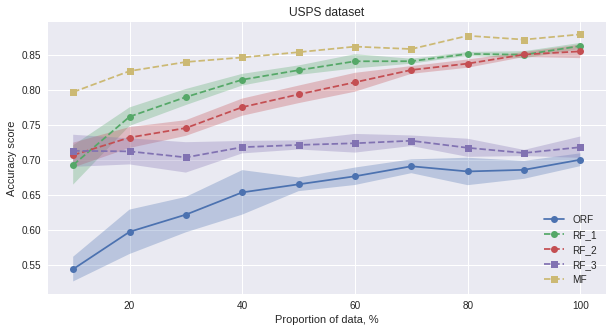

In [37]:
plt.figure(figsize=(10, 5))
plt.title('USPS dataset')

plt.plot(list(range(10, 110, 10)), results['usps']['DT'][0], marker='o', label='ORF')
plt.fill_between(list(range(10, 110, 10)), results['usps']['DT'][0] - results['usps']['DT'][1], 
                 results['usps']['DT'][0] + results['usps']['DT'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['usps']['RF_1'][0], ls='--', marker='o', label='RF_1')
plt.fill_between(list(range(10, 110, 10)), results['usps']['RF_1'][0] - results['usps']['RF_1'][1], 
                 results['usps']['RF_1'][0] + results['usps']['RF_1'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['usps']['RF_2'][0], ls='--', marker='o', label='RF_2')
plt.fill_between(list(range(10, 110, 10)), results['usps']['RF_2'][0] - results['usps']['RF_2'][1], 
                 results['usps']['RF_2'][0] + results['usps']['RF_2'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['usps']['RF_3'][0], ls='--', marker='s', label='RF_3')
plt.fill_between(list(range(10, 110, 10)), results['usps']['RF_3'][0] - results['usps']['RF_3'][1], 
                 results['usps']['RF_3'][0] + results['usps']['RF_3'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['usps']['MF'], ls='--', marker='s', label='MF')

plt.grid(True)
plt.legend();
plt.xlabel('Proportion of data, %')
plt.ylabel('Accuracy score')

Text(0, 0.5, 'Accuracy score')

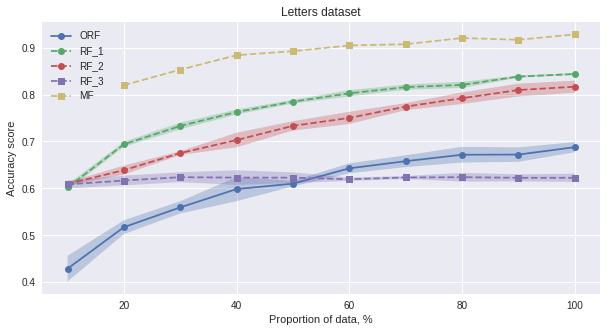

In [39]:
plt.figure(figsize=(10, 5))
plt.title('Letters dataset')

plt.plot(list(range(10, 110, 10)), results['letters']['DT'][0], marker='o', label='ORF')
plt.fill_between(list(range(10, 110, 10)), results['letters']['DT'][0] - results['letters']['DT'][1], 
                 results['letters']['DT'][0] + results['letters']['DT'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['letters']['RF_1'][0], ls='--', marker='o', label='RF_1')
plt.fill_between(list(range(10, 110, 10)), results['letters']['RF_1'][0] - results['letters']['RF_1'][1], 
                 results['letters']['RF_1'][0] + results['letters']['RF_1'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['letters']['RF_2'][0], ls='--', marker='o', label='RF_2')
plt.fill_between(list(range(10, 110, 10)), results['letters']['RF_2'][0] - results['letters']['RF_2'][1], 
                 results['letters']['RF_2'][0] + results['letters']['RF_2'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['letters']['RF_3'][0], ls='--', marker='s', label='RF_3')
plt.fill_between(list(range(10, 110, 10)), results['letters']['RF_3'][0] - results['letters']['RF_3'][1], 
                 results['letters']['RF_3'][0] + results['letters']['RF_3'][1], alpha=0.3)

plt.plot(list(range(20, 110, 10)), results['letters']['MF'], ls='--', marker='s', label='MF')

plt.grid(True)
plt.legend();
plt.xlabel('Proportion of data, %')
plt.ylabel('Accuracy score')

Text(0, 0.5, 'Accuracy score')

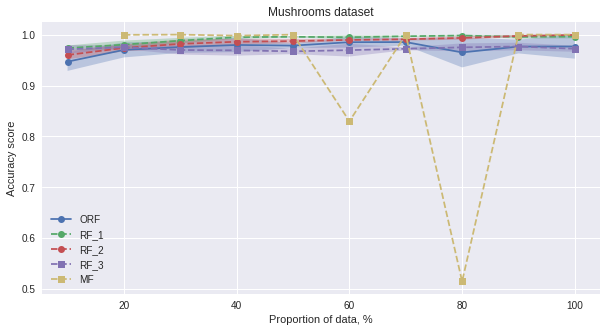

In [43]:
plt.figure(figsize=(10, 5))
plt.title('Mushrooms dataset')

plt.plot(list(range(10, 110, 10)), results['mushrooms']['DT'][0], marker='o', label='ORF')
plt.fill_between(list(range(10, 110, 10)), results['mushrooms']['DT'][0] - results['mushrooms']['DT'][1], 
                 results['mushrooms']['DT'][0] + results['mushrooms']['DT'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['mushrooms']['RF_1'][0], ls='--', marker='o', label='RF_1')
plt.fill_between(list(range(10, 110, 10)), results['mushrooms']['RF_1'][0] - results['mushrooms']['RF_1'][1], 
                 results['mushrooms']['RF_1'][0] + results['mushrooms']['RF_1'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['mushrooms']['RF_2'][0], ls='--', marker='o', label='RF_2')
plt.fill_between(list(range(10, 110, 10)), results['mushrooms']['RF_2'][0] - results['mushrooms']['RF_2'][1], 
                 results['mushrooms']['RF_2'][0] + results['mushrooms']['RF_2'][1], alpha=0.3)

plt.plot(list(range(10, 110, 10)), results['mushrooms']['RF_3'][0], ls='--', marker='s', label='RF_3')
plt.fill_between(list(range(10, 110, 10)), results['mushrooms']['RF_3'][0] - results['mushrooms']['RF_3'][1], 
                 results['mushrooms']['RF_3'][0] + results['mushrooms']['RF_3'][1], alpha=0.3)

plt.plot(list(range(20, 110, 10)), results['mushrooms']['MF'], ls='--', marker='s', label='MF')

plt.grid(True)
plt.legend();
plt.xlabel('Proportion of data, %')
plt.ylabel('Accuracy score')

In [ ]:
33